In [64]:
!which pip
!pip freeze | grep albumentations
!which python

/workspace/kaggle-notebooks/ink-detection/venv/bin/pip
albumentations==1.3.0
/workspace/kaggle-notebooks/ink-detection/venv/bin/python


## Import

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gc
import glob
import pathlib
from pathlib import Path
from typing import List, Tuple
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import os
from torchvision.transforms import ToPILImage
import albumentations as A
import timm
import pandas as pd
from collections import defaultdict

## Config

In [66]:
class EnvironmentConfig:
    base_path = "/workspace/kaggle-notebooks/ink-detection"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_path = os.path.join(base_path, "train")

class DnnConfig:
    epochs = 5
    lr = 1e-4
    batch_size = 128
    image_size = 128
    use_amp = True
    sigmoid_thd = 0.4
    
class DomainConfig:
    buffer = 30
    z_start = 27
    z_dim = 10    

class Config:
    environment = EnvironmentConfig()    
    dnn = DnnConfig()
    domain = DomainConfig()



In [67]:
TEST_CONFIG = Config()

base_index = os.environ.get("INDEX")
if base_index is None:
    base_index = "a"
MODE = "test"
BASE_PATH = os.path.join(TEST_CONFIG.environment.base_path, MODE)
PREFIX = os.path.join(BASE_PATH, base_index)
BUFFER = TEST_CONFIG.domain.buffer
Z_START = TEST_CONFIG.domain.z_start # First slice in the z direction to use
Z_DIM = TEST_CONFIG.domain.z_dim   # Number of slices in the z direction
LEARNING_RATE = TEST_CONFIG.dnn.lr
BATCH_SIZE = TEST_CONFIG.dnn.batch_size
EPOCHS = TEST_CONFIG.dnn.epochs
DEVICE = TEST_CONFIG.environment.device
IMSIZE = TEST_CONFIG.dnn.image_size
SIGMOID_THD = TEST_CONFIG.dnn.sigmoid_thd
USE_AMP = TEST_CONFIG.dnn.use_amp


## Dataset

In [68]:
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack: torch.Tensor, pixels):
        self.image_stack = image_stack
        self.pixels = pixels
        
    def __len__(self):
        return len(self.pixels)
    
    def __getitem__(self, index):
        y, x = self.pixels[index]        
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        return subvolume

## Transforms

In [69]:
# img_transforms = A.Compose([A.Resize(IMSIZE, IMSIZE, p=1.0)])

## Model

In [70]:
class Model(nn.Module):
    def __init__(self, name="", pretrained=True):
        super(Model, self).__init__()

        # # Use timm
        # model = timm.create_model(name, pretrained=pretrained)

        # clsf = model.default_cfg['classifier']
        # n_features = model._modules[clsf].in_features
        # model._modules[clsf] = nn.Identity()

        # self.fc = nn.Sequential(
        #     nn.Linear(n_features, 32),
        #     nn.Linear(32, 1)
        # )
        
        model = nn.Sequential(
            nn.Conv3d(1, 32, 3, 1, 1), nn.BatchNorm3d(32), nn.MaxPool3d(2, 2),
            nn.Conv3d(32, 128, 3, 1, 1), nn.BatchNorm3d(128), nn.MaxPool3d(2, 2),
            nn.Flatten(start_dim=1),
        )
        fc = nn.Sequential(
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(1)
        )
        self.model = model
        self.fc = fc

    def forward(self, x):
        out = self.model(x)
        out = self.fc(out)
        return out

In [71]:
model = Model().to(DEVICE)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

## Create Resources

100%|██████████| 10/10 [00:00<00:00, 27.24it/s]


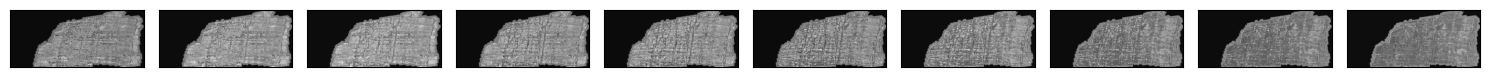

In [72]:
mask = np.array(Image.open(PREFIX+"/mask.png").convert('1'))
rect = (1100, 3500, 700, 950)
# Load the 3d x-ray scan, one slice at a time
images = [
  np.array(
    Image.open(
      filename
    ),
    dtype=np.float32
  ) / 65535.0
  for filename in tqdm(sorted(glob.glob(os.path.join(PREFIX, "surface_volume", "*.tif")))[Z_START:Z_START+Z_DIM])
]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)

fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
for image, ax in zip(images, axes):
  ax.imshow(np.array(Image.fromarray(image).resize((image.shape[1]//20, image.shape[0]//20)), dtype=np.float32), cmap='gray')
  ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

## Inference

In [73]:
def get_pixels(path: str):
    mask = np.array(Image.open(path+"/mask.png").convert('1'))

    rect = (1100, 3500, 700, 950)

    pixels = []
    for pixel in zip(*np.where(mask == 1)):
        if pixel[1] < BUFFER or pixel[1] >= mask.shape[1]-BUFFER or pixel[0] < BUFFER or pixel[0] >= mask.shape[0]-BUFFER:
            continue # Too close to the edge
        if pixel[1] >= rect[0] and pixel[1] <= rect[0]+rect[2] and pixel[0] >= rect[1] and pixel[0] <= rect[1]+rect[3]:
            pixels.append(pixel)
        else:
            pixels.append(pixel)
    return pixels

In [74]:
test_path = pathlib.Path(BASE_PATH)
test_fragments = [test_path / fragment_name for fragment_name in test_path.iterdir()]
print("All fragments:", test_fragments)

All fragments: [PosixPath('/workspace/kaggle-notebooks/ink-detection/test/a'), PosixPath('/workspace/kaggle-notebooks/ink-detection/test/b')]


In [75]:
print("Generating pixel lists...")
# Split our dataset into train and val. The pixels inside the rect are the 
# val set, and the pixels outside the rect are the train set.
pixels_inside_rect = []
pixels_outside_rect = []
for pixel in zip(*np.where(mask == 1)):
    if pixel[1] < BUFFER or pixel[1] >= mask.shape[1]-BUFFER or pixel[0] < BUFFER or pixel[0] >= mask.shape[0]-BUFFER:
        continue # Too close to the edge
    if pixel[1] >= rect[0] and pixel[1] <= rect[0]+rect[2] and pixel[0] >= rect[1] and pixel[0] <= rect[1]+rect[3]:
        pixels_inside_rect.append(pixel)
    else:
        pixels_outside_rect.append(pixel)

Generating pixel lists...


In [76]:
pred_images = []
model.eval()
for test_fragment in test_fragments:
    outputs = []
    pixels = get_pixels(test_fragment.as_posix())
    eval_dset = SubvolumeDataset(image_stack, pixels)
    eval_loader = data.DataLoader(eval_dset, batch_size=BATCH_SIZE, shuffle=False)
    first_subvolumes = None
    with torch.no_grad():
        for i, subvolumes in enumerate(tqdm(eval_loader)):         
            if first_subvolumes is None:
                first_subvolumes = subvolumes
            output = model(subvolumes.to(DEVICE)).view(-1).sigmoid().cpu().numpy()
            outputs.append(output)
    # we only load 1 fragment at a time
    image_shape = first_subvolumes.shape[-2:]

    pred_image = np.zeros(image_shape, dtype=np.uint8)
    outputs = np.concatenate(outputs)
    for (y, x), prob in zip(pixels[:outputs.shape[0]], outputs):
        pred_image[y ,x] = prob > SIGMOID_THD
    pred_images.append(pred_image)
    
    del eval_dset
    gc.collect()
    print("Finished", test_fragment)

100%|██████████| 83666/83666 [35:03<00:00, 39.77it/s]   


IndexError: index 4998 is out of bounds for axis 1 with size 61

## Submission

In [ ]:
def rle(output):
    flat_img = np.where(output.flatten().cpu() > SIGMOID_THD, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [ ]:
rle_output = rle(output)
# This doesn't make too much sense, but let's just output in the required format
# so notebook works as a submission. :-)
print("Id,Predicted\na," + rle_output + "\nb," + rle_output, file=open('submission.csv', 'w'))